# imports

In [1]:
import os
from typing import Optional
import numpy as np
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [110]:
DATAPATH = r"D:\projects\Lung Disease Detection"
TRAINPATH = DATAPATH + r"\CtScans"

TRAINPATH_diseased = TRAINPATH + r"\diseased"
TRAINPATH_healthy = TRAINPATH + r"\not_diseased"

TESTPATH = DATAPATH + r"\test_ctscans"
TESTPATH_diseased = TESTPATH + r"\diseased"
TESTPATH_healthy = TESTPATH + r"\non_diseased"


# EDA

In [6]:
image1 = cv2.imread(TRAINPATH + r"\diseased\1.png")

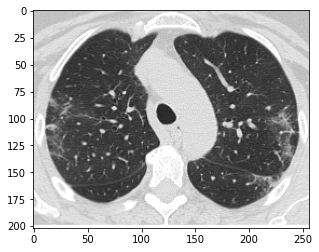

In [19]:
plt.imshow(image1);

In [8]:
image1.shape

(202, 256, 3)

> RGB encoding aren't helping 
we should reduce the dimensionality

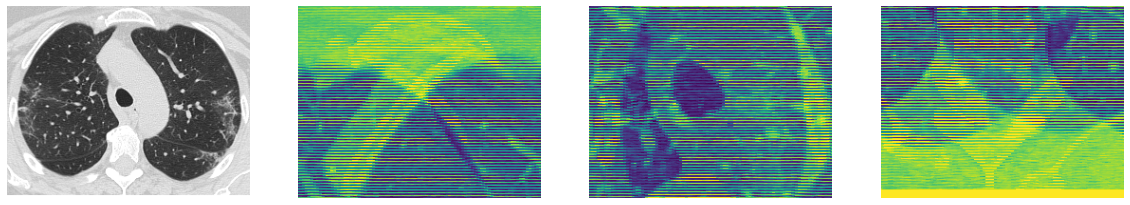

In [113]:
# see if we can simply remove any color channel

width = image1.shape[0]
hieght = image1.shape[1]

red_channel= image1.reshape(3, width,hieght).transpose(1,2,0)[:,:,0]
green_channel = image1.reshape(3, width,hieght).transpose(1,2,0)[:,:,1]
blue_channel = image1.reshape(3, width,hieght).transpose(1,2,0)[:,:,2]
# plot
images = [image1, red_channel, green_channel, blue_channel]

fig, axes = plt.subplots(1, len(images), figsize=(20, 5))
for ind,im in enumerate(images):
    axes[ind].imshow(im) ,axes[ind].axis('off')

> as we can see we can't simpely separate channels manualy 

## using opencv to convert RGB to gray

gray image shape (202, 256)


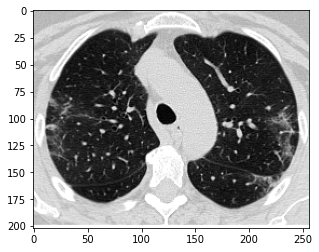

In [115]:
image_gray = cv2.cvtColor(image1, cv2.COLOR_BGR2GRAY)
print("gray image shape",image_gray.shape)
plt.imshow(image_gray, cmap='gray');

### ***NOTE: i had to manually rename some image as they contain spicial characters causing disablilty to read them***

In [103]:
def read_images(
    path,
    extensions: Optional[set[str]] = ('jpg', 'png', 'jpeg') )\
        -> list[np.ndarray]:
    """
    Reads all images from a directory.

    :param path: Path to the directory.
    :param extensions: Set of allowed extensions.
    :return: List of images.
    """
    #Find the Images with the Extenstion in the Tupple

    images_array = [cv2.imread(path +"//"+ file_) 
        for file_ in os.listdir(path) 
        if file_.endswith(tuple(extensions))]

    return images_array


images_array =read_images(path=TRAINPATH_diseased)

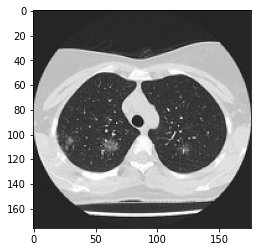

In [108]:
plt.imshow(images_array[-1]);

In [111]:
# read train images
train_images_diseased = read_images(path=TRAINPATH_diseased)
# train_images.extend(read_images(path=TRAINPATH_healthy))
train_images_healthy= read_images(path=TRAINPATH_healthy)

# read test images
test_images_diseased = read_images(path=TESTPATH_diseased)
test_images_healthy = read_images(path=TESTPATH_healthy)

print("train_images_diseased",len(train_images_diseased))
print("train_images_healthy",len(train_images_healthy))
print("test_images_diseased",len(test_images_diseased))
print("test_images_healthy",len(test_images_healthy))

train_images_diseased 756
train_images_healthy 757
test_images_diseased 84
test_images_healthy 84


> the dataset is small so we'll try to augmented

**first resize the images' dimensions**

In [131]:
shapes = sorted([max(im.shape) for im in train_images_diseased ], reverse=True)
print(shapes[:4])
print(shapes[50:54])
print(shapes[-4:])

[535, 442, 442, 442]
[442, 442, 442, 442]
[176, 176, 176, 176]


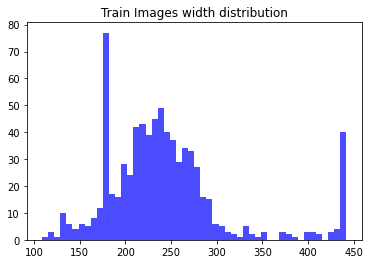

In [144]:
widths = [im.shape[0] for im in train_images_diseased ]
plt.title("Train Images width distribution")
plt.hist(x=widths, bins=50, color='blue', alpha=0.7);

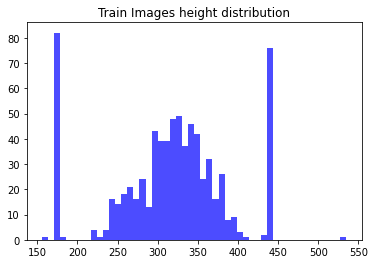

In [169]:
hieghts = [im.shape[1] for im in train_images_diseased ]
plt.title("Train Images height distribution")
plt.hist(x=hieghts, bins=50, color='blue', alpha=0.7);

In [153]:
# get off te outliers
min_width = sorted(widths)[10]
min_height = sorted(hieghts)[10]
max_width = sorted(widths)[-10]
max_height = sorted(hieghts)[-10]
print("max_width",max_width)
print("max_height",max_height)
print("min_width",min_width)
print("min_height",min_height)

max_width 442
max_height 442
min_width 132
min_height 176


>**we will taking a mid point shape**

>**if failed we will make the image's dimensinos square i.e (x,x)**

In [157]:
rescaled_shape = (max_width+min_width)//2  ,(max_height+min_height)//2
print("rescaled_shape",rescaled_shape)

rescaled_shape (287, 309)


In [158]:
train_images_diseased[0].shape , cv2.resize(train_images_diseased[0], rescaled_shape).shape

((442, 442, 3), (309, 287, 3))

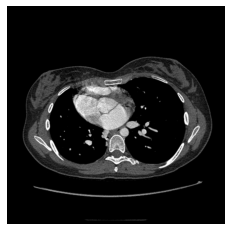

In [168]:
fig, ax = plt.subplots()
plt.imshow(train_images_diseased[0]);
ax.axis("off");

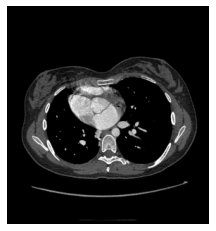

In [167]:
fig, ax = plt.subplots()
plt.imshow(cv2.resize(train_images_diseased[0], rescaled_shape));
ax.axis("off");

In [234]:
def rescale_images(
    images: list[np.ndarray],
    new_shape: tuple[int, int])\
        -> list[np.ndarray]:
    """
    Rescales images to a new shape.

    :param images: List of images.
    :param new_shape: New shape.
    """

    return [cv2.resize(im, new_shape) for im in images]

In [171]:
train_images_diseased_rsc = rescale_images(train_images_diseased, rescaled_shape)
train_images_diseased_rsc[-1].shape

(309, 287, 3)

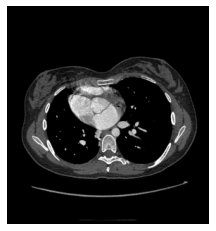

In [173]:
fig, ax = plt.subplots()
plt.imshow(cv2.resize(train_images_diseased_rsc[0], rescaled_shape));
ax.axis("off");

In [225]:
def standardize_image(
    image: np.ndarray,
    ) -> np.ndarray:
    """
    Standardizes an image.
    center the image, and normalize the pixel values to be between 0 and 1.

    :param image: Image to standardize.
    :return: Standardized image.
    """
    mean = np.mean(image[:])
    std = np.std(image[:])

    return (image - mean) / std

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


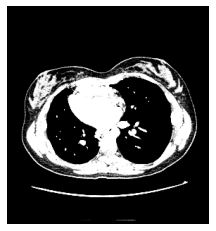

In [214]:
fig, ax = plt.subplots()
plt.imshow(standardize_images(standardized_images[0]));
ax.axis("off");

In [216]:
def standardize_images(
    images: list[np.ndarray],
    ) -> list[np.ndarray]:
    """
    Standardizes images.
    
    :param images: List of images.
    :return: List of standardized images.
    """
    return list(map(standardize_image, images))

In [217]:
def normalize_image(
    image: np.ndarray,
    ) -> np.ndarray:
    """
    Normalizes an image.

    :param image: Image.
    :return: Normalized image.
    """
    return image / 255.0

def normalize_images(
    images: list[np.ndarray],
    ) -> list[np.ndarray]:
    """
    Normalizes images.

    :param images: List of images.
    :return: List of normalized images.
    """
    return list(map(normalize_image, images))


In [222]:
def clip_image(
    image: np.ndarray,
    ) -> np.ndarray:
    """
    Clips an image.

    :param image: Image.
    :return: Clipped image.
    """
    return np.clip(image, 0.0, 1.0)

def clip_images(
    images: list[np.ndarray],
    ) -> list[np.ndarray]:
    """
    Clips images.

    :param images: List of images.
    :return: List of clipped images.
    """
    return list(map(clip_image, images))

In [223]:
clean_train_images_diseased = clip_images(
        standardize_images(
                normalize_images(
                rescale_images(
                        train_images_diseased
                        , rescaled_shape)
                )
        )
)

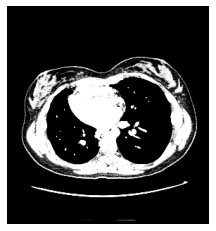

In [224]:
fig, ax = plt.subplots()
plt.imshow(clean_train_images_diseased[0]);
ax.axis("off");

In [269]:
def convert_images_to_gray(
    images: list[np.ndarray],
    ) -> list[np.ndarray]:
    """
    Converts images to grayscale.

    :param images: List of images.
    :return: List of grayscale images.
    """
    res = list(map(lambda im: cv2.cvtColor(im, cv2.COLOR_BGR2GRAY), images))
    return res

In [228]:
clean_train_images_diseased[0].shape

(309, 287, 3)

In [229]:
set([i.shape for i in  clean_train_images_diseased])

{(309, 287, 3)}

In [232]:
# conv_clean_train_images_diseased = convert_images_to_gray(clean_train_images_diseased)

# fig, ax = plt.subplots()
# plt.imshow(conv_clean_train_images_diseased[0]);
# ax.axis("off");

**if convert to gray after the whole preprocessing it returns this error**

error: OpenCV(4.5.3) c:\users\runneradmin\appdata\local\temp\pip-req-build-sn_xpupm\opencv\modules\imgproc\src\color.simd_helpers.hpp:94: error: (-2:Unspecified error) in function '__cdecl cv::impl::`anonymous-namespace'::CvtHelper<struct cv::impl::`anonymous namespace'::Set<3,4,-1>,struct cv::impl::A0xf6eb93b9::Set<1,-1,-1>,struct cv::impl::A0xf6eb93b9::Set<0,2,5>,2>::CvtHelper(const class cv::_InputArray &,const class cv::_OutputArray &,int)'
> Unsupported depth of input image:
>     'VDepth::contains(depth)'
> where
>     'depth' is 6 (CV_64F)

In [231]:
conv = convert_images_to_gray(train_images_diseased)
conv[0].shape

(442, 442)

# **Results**

In [262]:
# preprocess pipeline
def preprocess_images(
    images: list[np.ndarray],
    rescaled_shape: [tuple[int, int]],
    ) -> list[np.ndarray]:
    """
    Preprocesses images.

    :param images: List of images.
    :return: List of preprocessed images.
    """
    # 1 - convert to grayscale
    images = convert_images_to_gray(images)
    # 2 - rescale
    images = rescale_images(images, rescaled_shape)
    # 3 - normalize
    images = normalize_images(images)
    # 4 - standardize
    images = standardize_images(images)
    # 5 - clip
    images = clip_images(images)
    # return list(map(clip_image, standardize_images(normalize_images(images))))
    return images

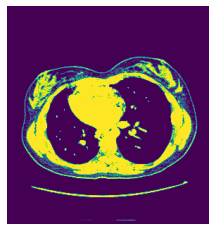

In [270]:
preprocessed_images = preprocess_images(train_images_diseased, rescaled_shape)

fig, ax = plt.subplots()
plt.imshow(preprocessed_images[0]);
ax.axis("off");

In [265]:
preprocessed_images[0].shape

(309, 287)

**it was  just the cmap**

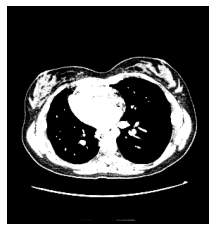

In [266]:
fig, ax = plt.subplots()
plt.imshow(preprocessed_images[0], cmap="gray");
ax.axis("off");